# Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from glob import glob

import pyopia.classify
import pyopia.process
import pyopia.statistics
import pyopia.io

# List raw data files

In [3]:
# put some example images in a folder defined by raw_data
# you can find examples here: https://pysilcam.blob.core.windows.net/test-data/example_silc_data.zip
raw_data = "raw_data"
raw_files = glob(os.path.join(raw_data, '*.silc'))
raw_files

['raw_data\\D20181101T142731.838206.silc',
 'raw_data\\D20181101T142732.772669.silc',
 'raw_data\\D20181101T142733.765097.silc',
 'raw_data\\D20181101T142734.292793.silc']

# Define non-defult settings for anlayis, or custom functions

In [4]:
from functools import partial
# The inbuilt partial function allows redefining of optional input arguments.
# This means that lower-level functions in pyopia.process that contain several optional settings
# can be changed using partial without having to pass these optional inputs through all levels in the code.

# define a modified export_particles function, that states an output directory (test_export)
# for saving exported ROIs
extractparticles_function = partial(pyopia.process.extract_particles,
                                    export_outputpath='test_export')

# give this extractparticles_function function to statextract
# and if you want to, edit settings in statextract
# when we call pyopia.process_image later, we will give it statextract_function to apply these options 
statextract_function = partial(pyopia.process.statextract,
                           minimum_area=12, threshold=0.98, real_time_stats=False,
                           max_coverage=30, max_particles=5000,
                           extractparticles_function=extractparticles_function)

# Initialise the CNN

In [5]:
# initialise the Classify class
cl = pyopia.classify.Classify()

# at this point you could overwrite custom classification functions,
# like cl.proc_predict() to work with a different classification network

# load the model (this example can be found here:
#    https://github.com/SINTEF/PySilCam/wiki/ml_models/keras_model.zip)
cl.load_model(model_path="C:\model\keras_model.h5")

# Calculate particle statistics for each image

In [6]:
# define a place for storing the summary statistics using pyopia.io.write_stats
# prefix filename and path. 
datafile_hdf = 'proc/test' # The actual filename will be 'proc/test-STATS.h5' in this case

# loop through the raw_files list, and process the images
for filename in raw_files:
    
    # load a silcam image
    img = np.load(filename, allow_pickle=False)
    
    # get the timestamp of the image (in this case from the filename)
    timestamp = pd.to_datetime(os.path.splitext(os.path.basename(filename))[0][1:])

    # setup the 'data' tuple with an image number, timestamp and the image
    data = (1, timestamp, img)

    # call process_image
    stats = pyopia.process.process_image(cl, data, statextract_function=statextract_function)
    
    # rather than appending an ever-growing stats daraframe on each image, it is best to just append these data to
    # the *-STATS.h5 file, which will grow on each loop
    pyopia.io.write_stats(datafile_hdf, stats)

Processing time stamp 2018-11-01 14:27:31.838206
segment
clean
2.2% saturation
measure
  121 particles found
EXTRACTING 121 IMAGES from 121
  Image 1 processed in 2.53 sec (0.4 Hz). 
Processing time stamp 2018-11-01 14:27:32.772669
segment
clean
2.3% saturation
measure
  120 particles found
EXTRACTING 120 IMAGES from 120
  Image 1 processed in 2.46 sec (0.4 Hz). 
Processing time stamp 2018-11-01 14:27:33.765097
segment
clean
2.2% saturation
measure
  139 particles found
EXTRACTING 139 IMAGES from 139
  Image 1 processed in 2.76 sec (0.4 Hz). 
Processing time stamp 2018-11-01 14:27:34.292793
segment
clean
2.2% saturation
measure
  96 particles found
EXTRACTING 96 IMAGES from 96
  Image 1 processed in 2.57 sec (0.4 Hz). 


## The STATS.h5 data

In [7]:
# display metadata in the h5
pyopia.io.show_h5_meta(datafile_hdf + '-STATS.h5')

Modified:
    2022-03-30 14:18:10.766392
PyOpia version:
    0.0.8


In [8]:
# load the stats DataFrame from the h5 file
stats = pd.read_hdf(datafile_hdf + '-STATS.h5', 'ParticleStats/stats')
stats

,major_axis_length,minor_axis_length,equivalent_diameter,solidity,minr,minc,maxr,maxc,probability_oil,probability_other,probability_bubble,probability_faecal_pellets,probability_copepod,probability_diatom_chain,probability_oily_gas,export name,timestamp,saturation
0,24.124216,18.275080,19.963065,0.780549,3.0,2263.0,24.0,2288.0,1.932029e-01,0.039244,0.746780,5.709144e-04,0.000669,0.001253,0.018281,D20181101T142731.838206-PN0,2018-11-01 14:27:31.838206,2.209868
1,30.764984,18.696429,22.482796,0.767892,5.0,2086.0,29.0,2116.0,1.916395e-01,0.029599,0.721615,1.161073e-03,0.000250,0.000212,0.055524,D20181101T142731.838206-PN1,2018-11-01 14:27:31.838206,2.209868
2,17.180819,14.007297,14.625466,0.753363,11.0,464.0,31.0,481.0,1.684393e-01,0.029969,0.570907,2.164013e-03,0.002839,0.000426,0.225255,D20181101T142731.838206-PN2,2018-11-01 14:27:31.838206,2.209868
3,33.121971,10.344231,15.430353,0.554896,19.0,2066.0,42.0,2098.0,3.575202e-01,0.083664,0.510231,2.286552e-03,0.000728,0.000492,0.045078,D20181101T142731.838206-PN3,2018-11-01 14:27:31.838206,2.209868
4,5.138213,3.243740,4.068429,0.866667,26.0,298.0,30.0,303.0,3.010116e-01,0.061974,0.540936,5.174641e-03,0.003111,0.008986,0.078807,D20181101T142731.838206-PN4,2018-11-01 14:27:31.838206,2.209868
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,15.752083,10.391067,10.998080,0.703704,1917.0,1995.0,1931.0,2010.0,2.663096e-01,0.082479,0.616474,4.939492e-04,0.001359,0.000501,0.032384,D20181101T142734.292793-PN91,2018-11-01 14:27:34.292793,2.235108
92,11.591888,5.906684,7.312733,0.763636,1972.0,380.0,1982.0,390.0,1.448163e-01,0.038016,0.686591,3.358920e-03,0.005908,0.005809,0.115501,D20181101T142734.292793-PN92,2018-11-01 14:27:34.292793,2.235108
93,33.338860,29.957035,30.922531,0.842873,1996.0,1201.0,2029.0,1234.0,2.219761e-01,0.086649,0.613644,2.151141e-03,0.003612,0.008018,0.063950,D20181101T142734.292793-PN93,2018-11-01 14:27:34.292793,2.235108
94,40.720891,38.094804,39.202042,0.900746,2001.0,192.0,2044.0,234.0,7.523940e-07,0.000054,0.999801,1.830991e-08,0.000012,0.000002,0.000130,D20181101T142734.292793-PN94,2018-11-01 14:27:34.292793,2.235108


# Analysis, statistics and plotting

Text(0, 0.5, 'Volume Distribution [uL/sample vol.]')

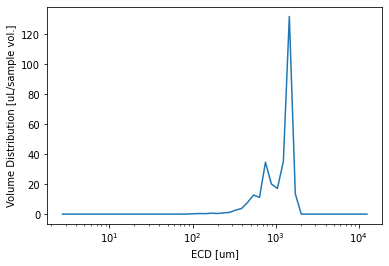

In [9]:
# there are lots of functions in pyopia.statistics. Here is just an example.

# Calculate the volume distribution from the stats DataFrame.
dias, vd = pyopia.statistics.vd_from_stats(stats, 24)

# plot the volume distribution
plt.plot(dias, vd)
plt.xscale('log')
plt.xlabel('ECD [um]')
plt.ylabel('Volume Distribution [uL/sample vol.]')